In [2]:
%pip install tensorflow seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


Note: you may need to restart the kernel to use updated packages.


load dataset

In [3]:
# Load Pima Indian Diabetes dataset
df = pd.read_csv("F:/RUSL/4- 1/ICT 4302 - Intelligent Systems/miniProject1/diabetes.csv")

df.columns = df.columns.str.strip()  # Clean header spaces
for col in df.columns:
    if col != 'Outcome':
        df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert non-numeric to NaN

numeric_df = df.select_dtypes(include=['number'])

X = numeric_df.drop('Outcome', axis=1)
y = numeric_df['Outcome']


df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Data preprocessing

step 1 - Replace invalid zeros with NaN (handle missing values)

In [4]:
cols_with_missing = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# Replace 0 with np.nan only for these features
df[cols_with_missing] = df[cols_with_missing].replace(0, np.nan)


In [5]:
# Remove rows with too many missing values
def drop_rows_with_many_missing(df, threshold_cols=4):
    return df[df[cols_with_missing].isnull().sum(axis=1) < threshold_cols]

df = drop_rows_with_many_missing(df)

In [6]:
# Define columns for different strategies
median_columns = ["Glucose", "BloodPressure"]
knn_columns = ["SkinThickness", "Insulin", "BMI"]

step 2 - fill missing values using the median of the same class

In [7]:
# Apply same-class median imputation
def impute_same_class_median(df, columns, class_col="Outcome"):
    for col in columns:
        df[col] = df.groupby(class_col)[col].transform(lambda x: x.fillna(x.median()))
    return df

df = impute_same_class_median(df, median_columns)

In [8]:
# Apply KNN Imputer for selected columns
def knn_impute(df, columns, n_neighbors=5):
    imputer = KNNImputer(n_neighbors=n_neighbors)
    df[columns] = imputer.fit_transform(df[columns])
    return df

df = knn_impute(df, knn_columns)

In [9]:
# Normalize features (optional but recommended)
from sklearn.preprocessing import MinMaxScaler


features = df.columns[:-1]  # Exclude Outcome
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

In [10]:
print("✅ Cleaned dataset ready for model:")
display(df.head())

✅ Cleaned dataset ready for model:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.352941,0.670968,0.489796,0.304348,0.213221,0.314928,0.234415,0.483333,1
1,0.058824,0.264516,0.428571,0.239130,0.128125,0.171779,0.116567,0.166667,0
2,0.470588,0.896774,0.408163,0.106522,0.106010,0.104294,0.253629,0.183333,1
3,0.058824,0.290323,0.428571,0.173913,0.096154,0.202454,0.038002,0.000000,0
4,0.000000,0.600000,0.163265,0.304348,0.185096,0.509202,0.943638,0.200000,1


data split

In [11]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


build custom keras model

In [12]:
model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary output
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
#

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                144       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________


Train the model

In [14]:
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=2)
#change epochs as needed

Epoch 1/50
35/35 - 3s - loss: 6.7183 - accuracy: 0.6069 - val_loss: 1.2110 - val_accuracy: 0.4516 - 3s/epoch - 99ms/step
Epoch 2/50
35/35 - 0s - loss: 1.1759 - accuracy: 0.3714 - val_loss: 0.6998 - val_accuracy: 0.4032 - 231ms/epoch - 7ms/step
Epoch 3/50
35/35 - 0s - loss: 0.8363 - accuracy: 0.5127 - val_loss: 0.6524 - val_accuracy: 0.6935 - 239ms/epoch - 7ms/step
Epoch 4/50
35/35 - 0s - loss: 0.7670 - accuracy: 0.5888 - val_loss: 0.6370 - val_accuracy: 0.6935 - 231ms/epoch - 7ms/step
Epoch 5/50
35/35 - 0s - loss: 0.7599 - accuracy: 0.6159 - val_loss: 0.6704 - val_accuracy: 0.6935 - 240ms/epoch - 7ms/step
Epoch 6/50
35/35 - 0s - loss: 0.7183 - accuracy: 0.6304 - val_loss: 0.6462 - val_accuracy: 0.6935 - 221ms/epoch - 6ms/step
Epoch 7/50
35/35 - 0s - loss: 0.6924 - accuracy: 0.6413 - val_loss: 0.6356 - val_accuracy: 0.7258 - 223ms/epoch - 6ms/step
Epoch 8/50
35/35 - 0s - loss: 0.7040 - accuracy: 0.6449 - val_loss: 0.6378 - val_accuracy: 0.7258 - 188ms/epoch - 5ms/step
Epoch 9/50
35/35 -

Evaluate the model

In [15]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)

# Predict probabilities
y_pred_prob = model.predict(X_test).ravel()

# Convert to binary output
y_pred = (y_pred_prob >= 0.5).astype(int)

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Individual metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


5/5 [==============================] - 0s 3ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.68      0.97      0.80        99
           1       0.77      0.18      0.29        55

    accuracy                           0.69       154
   macro avg       0.73      0.58      0.55       154
weighted avg       0.71      0.69      0.62       154

Confusion Matrix:
[[96  3]
 [45 10]]
Accuracy: 0.6883116883116883
Precision: 0.7692307692307693
Recall: 0.18181818181818182
F1 Score: 0.29411764705882354


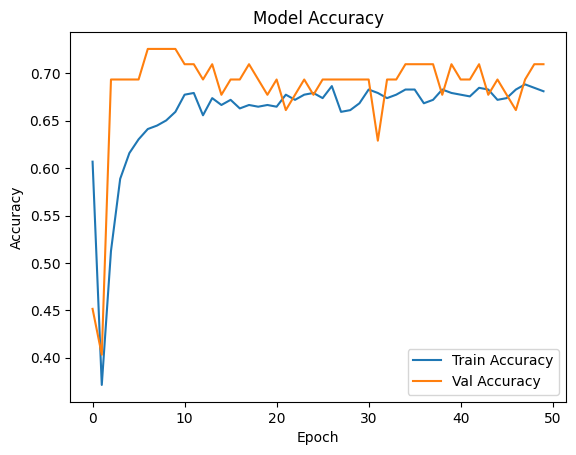

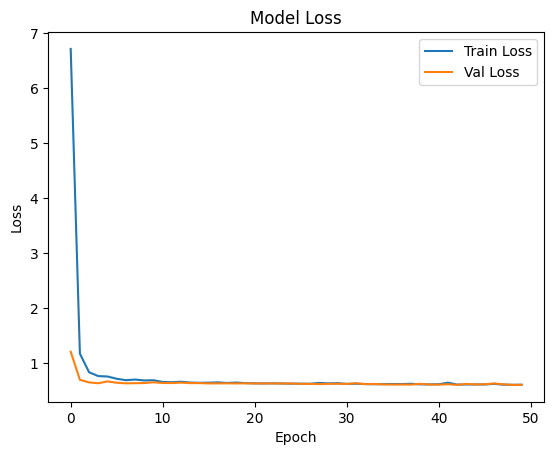

In [16]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
